In [1]:
#import all required libraries
import pandas as pd
import numpy as np
import holidays
import numpy as np
import datetime
from datetime import datetime
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgm
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

timeseries_df=pd.read_csv('synetica_dataframe.csv') #import the timeseries synetica dataset that contains the meter readings
                                                    #for 2018, 2019 and 2020
timeseries_df["timestamp"]=pd.to_datetime(timeseries_df["timestamp"])#convert timestamp to datetime type

meters=['MC063-L01/M3', 'MC065-L02/M1', 'MC061-L01/M8', 'MC043-L01/M3', 'MC062-L01/M7', 'MC010-L01/M1',
        'MC044-L01/M3', 'MC078-L02/M1', 'MC070-L01/M1', 'MC014-L01/M1', 'MC014_L02_M1', 'MC125-L01/M1', 
       'MC129-L01/M1', 'MC076-L01/M1' ] #define the meter IDs of the main electricity meters 
timeseries_main=timeseries_df[timeseries_df.name.isin(meters)] #create a data frame containing only readings from the main 
                                                                #electrcity meters
main_avg=timeseries_main.groupby(["timestamp"])[['reading']].mean() # take the mean of the readings from each meter at each
                                                                    # individual timestamp
main_avg=main_avg.reset_index() #reset the index of the new data frame


In [2]:
main_avg['Year']=main_avg['timestamp'].apply(lambda x:pd.Timestamp(x).strftime('%Y'))#create a column with only the year
main_avg['Date']=main_avg['timestamp'].apply(lambda x:pd.Timestamp(x).strftime('%Y-%m-%d'))#create a column with only dates
main_avg['Day']=main_avg['timestamp'].apply(lambda x:pd.Timestamp(x).strftime('%A'))#create a column with days of the week
main_avg['Month']=main_avg['timestamp'].apply(lambda x:pd.Timestamp(x).strftime('%m'))#create a column with only the month
main_avg['Hour']=main_avg['timestamp'].apply(lambda x:pd.Timestamp(x).strftime('%H'))#create a column with only the hour
main_avg['Minute']=main_avg['timestamp'].apply(lambda x:pd.Timestamp(x).strftime('%M'))#create a column with only the minute

In [3]:
#create term dates calander data frame 
rng = pd.date_range('2018-01-11', periods=1206, freq='D') # create a list of dates starting at 2018-01-01 and ending at 2021-04-30
term_dates = pd.DataFrame({'Date': rng}) #create a data frame from the above list
term=[] #initialise a list called term
term_as_int=[]#initialise a list called term_as_int
welcome_week_int=0 #set the integer for welcome week to 0
term_int=1 #set the integer for term time to 1
holiday_int=2 #set the integer for holiday to 0

# a for loop is used to determine the time of year according to term of all the dates in the dataframe, the term types are added to the term list
# for each date an integer is added to the term_as_int list according to the term type, this is so that it can be used for modelling
# dates of terms were found from Lancaster University calanders 
for i in range(0, (term_dates.index.max()+1)):
    if np.datetime64('2018-10-01')<=term_dates.Date[i]<=np.datetime64('2018-10-07') or np.datetime64('2019-09-30')<=term_dates.Date[i]<np.datetime64('2019-10-05') or np.datetime64('2020-09-21')<=term_dates.Date[i]<=np.datetime64('2020-10-02'):
        term.append('welcome_week')
        term_as_int.append(welcome_week_int)
    elif np.datetime64('2018-10-07')<term_dates.Date[i]<=np.datetime64('2018-12-14') or np.datetime64('2019-10-05')<=term_dates.Date[i]<=np.datetime64('2019-12-14') or np.datetime64('2020-10-02')<=term_dates.Date[i]<=np.datetime64('2020-12-11'):
        term.append('michelmas_term')
        term_as_int.append(term_int)       
    elif np.datetime64('2017-12-15')<=term_dates.Date[i]<=np.datetime64('2018-01-15') or np.datetime64('2018-12-14')<term_dates.Date[i]<np.datetime64('2019-01-14') or np.datetime64('2019-12-14')<term_dates.Date[i]<np.datetime64('2020-01-13') or np.datetime64('2020-12-11')<=term_dates.Date[i]<=np.datetime64('2021-01-08'):
        term.append('Christmas_break')
        term_as_int.append(holiday_int)
    elif np.datetime64('2018-01-15')<term_dates.Date[i]<=np.datetime64('2018-03-30') or np.datetime64('2019-01-14')<=term_dates.Date[i]<=np.datetime64('2019-03-29') or np.datetime64('2020-01-13')<=term_dates.Date[i]<=np.datetime64('2020-03-20') or np.datetime64('2021-01-08')<=term_dates.Date[i]<=np.datetime64('2021-03-19'):
        term.append('lent_term')
        term_as_int.append(term_int)
    elif np.datetime64('2018-03-30')<term_dates.Date[i]<np.datetime64('2018-04-23') or np.datetime64('2019-03-29')<=term_dates.Date[i]<np.datetime64('2019-04-29') or np.datetime64('2020-03-20')<term_dates.Date[i]<np.datetime64('2020-04-20') or np.datetime64('2021-03-19')<term_dates.Date[i]<np.datetime64('2021-04-16'):
        term.append('Easter_break')
        term_as_int.append(holiday_int)
    elif np.datetime64('2018-04-23')<=term_dates.Date[i]<=np.datetime64('2018-06-29') or np.datetime64('2019-04-29')<=term_dates.Date[i]<=np.datetime64('2019-06-28') or np.datetime64('2020-04-20')<=term_dates.Date[i]<=np.datetime64('2020-06-26') or  np.datetime64('2021-04-16')<=term_dates.Date[i]<=np.datetime64('2025-06-25'):
        term.append('summer_term')
        term_as_int.append(term_int)
    elif np.datetime64('2018-06-29')<term_dates.Date[i]<=np.datetime64('2018-10-01') or np.datetime64('2019-06-28')<term_dates.Date[i]<=np.datetime64('2019-09-30') or np.datetime64('2020-06-26')<term_dates.Date[i]<np.datetime64('2020-09-21'):
        term.append('summer_break')
        term_as_int.append(holiday_int)
    else:
        term.append(None)
        
term_dates['Term']=term # the term list is added as a column in the term dates data frame             
term_dates['Term_as_int']=term_as_int # the termas int list is added as a column in the term dates data frame  
term_dates["Date"]=pd.to_datetime(term_dates["Date"]) # ensure that the date column is a datetime datatype
term_dates['Date']=term_dates['Date'].apply(lambda x:pd.Timestamp(x).strftime('%Y-%m-%d')) #ensure the date column is in the correct form

#the term_dates dataframe can be merged with other dataframes when needed by matching the date of the timestamps 


In [4]:
#determine where the bank holidays occur in the data frame
uk_holidays=holidays.UnitedKingdom() #from the holidays package get the UK holiday dates
holidaydf=[] #initialise a holiday list
for i in range((main_avg.index.min()), (main_avg.index.max()+1)):
    date=str(main_avg.Date[i])#get the date from each row in the data frame
    holiday=uk_holidays.get(date)#find the date in the holidays dataframe and add the holiday to the holiday list
    holidaydf.append(holiday)#add the holiday to the list
main_avg['Holiday']=holidaydf#add the holiday list as a column in the meter readings dataframe

#create a type of day column where 0=workday, 1=weekend, 2=bank holiday
day_type_int=[] #initialise the day type integer list
day_type=[] # initialise the day type list
bank_holiday=2 # assign the integer 2 to bank holidays
weekend=1 #assign the integer 1 to weekends
weekday=0 # assign the integer 0 to weekdays

#use a for loop to assign the correct values to the day type and day type int lists depending on the holidays and day columns in the meter readings data frame
for i in range((main_avg.index.min()), (main_avg.index.max()+1)):
    #if the holiday column has a value of anything other than none then the day is a bank holiday regardless of the day of the week
    if main_avg['Holiday'][i]=="New Year's Day" or main_avg['Holiday'][i]== "Good Friday" or main_avg['Holiday'][i]== "Easter Monday [England, Wales, Northern Ireland]" or main_avg['Holiday'][i]== "May Day" or main_avg['Holiday'][i]=="Spring Bank Holiday" or main_avg['Holiday'][i]=="Late Summer Bank Holiday [England, Wales, Northern Ireland]" or main_avg['Holiday'][i]== "Christmas Day" or main_avg['Holiday'][i]== "Boxing Day" or main_avg['Holiday'][i]=="Boxing Day (Observed)" :
        day_type_int.append(bank_holiday)
        day_type.append('Bank_holiday')
    #if value of the holiday column is none then the type of day can be classified as a weekday or weekend
    else:  
        if main_avg.Day[i]=='Saturday' or main_avg.Day[i]=='Sunday':
            day_type_int.append(weekend)
            day_type.append('Weekend')
        else:
            day_type_int.append(weekday)
            day_type.append('Weekday')
       

        
main_avg['Day_type_as_int']=day_type_int #add the day type int list as a column in the meter readings data frame
main_avg['Day_type']=day_type #add the day type list as a column in the meter readings data frame

main_avg_df= pd.merge(main_avg, term_dates, how='inner', left_on='Date', right_on='Date')# merge the term dates data frame with the meter readings data frame

In [5]:
main_avg_df.Month=main_avg_df.Month.astype(float) #change the data type of the month column to a float so that it can be processed
main_avg_df.Hour=main_avg_df.Hour.astype(float)#change the data type of the hour column to a float so that it can be processed
main_avg_df.Minute=main_avg_df.Minute.astype(float)#change the data type of the minute column to a float so that it can be processed
#the useful features from the meter readings dataframe are defined 
features_with_reading=['reading','Day_type_as_int', 
          'Month', 'Hour','Minute', 'Term_as_int']
#the correlation of the features is determined and visualised
maincorr=main_avg_df[features_with_reading]
corrmat = maincorr.corr()
corrmat.style.background_gradient(cmap='coolwarm')

,reading,Day_type_as_int,Month,Hour,Minute,Term_as_int
reading,1.000000,-0.220825,-0.042633,0.252381,-0.000461,-0.235468
Day_type_as_int,-0.220825,1.000000,-0.002724,-0.000368,-0.000000,0.100778
Month,-0.042633,-0.002724,1.000000,-0.000627,-0.000008,0.083789
Hour,0.252381,-0.000368,-0.000627,1.000000,0.000071,0.000105
Minute,-0.000461,-0.000000,-0.000008,0.000071,1.000000,-0.000021
Term_as_int,-0.235468,0.100778,0.083789,0.000105,-0.000021,1.000000


In [6]:
#determine the correlations and order them by the absolute corerelation with the reading
#to show the effect of the variables on the reading
correlations = main_avg_df[features_with_reading].corr()
correlations['absolute_reading_correlation']=abs(correlations.reading)
correlations=correlations.sort_values(by=['absolute_reading_correlation'], ascending=False)
correlations['reading'].head(6)#display the correlations with the reading

reading            1.000000
Hour               0.252381
Term_as_int       -0.235468
Day_type_as_int   -0.220825
Month             -0.042633
Minute            -0.000461
Name: reading, dtype: float64

In [7]:
#create data frames with data from seperate years
main_18=main_avg_df.loc[(main_avg_df['Year']=='2018')]
main_19=main_avg_df.loc[(main_avg_df['Year']=='2019')]
main_20=main_avg_df.loc[(main_avg_df['Year']=='2020')]
main_21=main_avg_df.loc[(main_avg_df['Year']=='2021')]
main_1819=main_18.append(main_19)#join the 2018 and 2019 data frames

In [8]:
#define the features that will be used as inputs to the model (notice minute is removed due to its low correlation)
features=['Minute','Day_type_as_int', 'Month', 'Hour', 'Term_as_int']
X=main_1819[features] # define model input X as the values of the features in the meter reading data frame 
y=main_1819.reading # define the model output y as the reading values in the meter reading data frame 

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0) # split X and y into test and train data

In [36]:
#perform linear regression as a forecasting method 
reg=LinearRegression()  #initiate linear regression
reg.fit(train_X,train_y) #fit the linear regression model to the data
reg_preds=reg.predict(val_X) #test the model by predicted values for the validation set


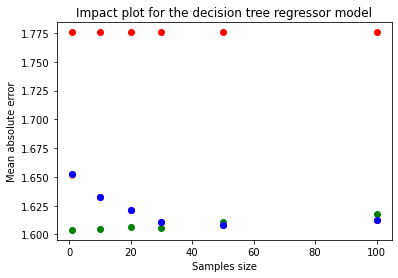

In [75]:
# create and optimise a decision tree forecasting model
depth=[5, 10, 20, 30,40, 50] # create a list of tree depth values
samples=[1, 10, 20,30, 50, 100] # create a list of values of samples
#use a for loop to create an impact plot of the effect of changing the depth and number of samples on the performance of the model
for d in depth:
   # use different point colours on the plot for different depths 
    if d==5:
        co='red'
    elif d==10:
        co='green'
    elif d==20:
        co='orange'
    elif d==30:
        co='yellow'
    elif d==40:
        co='magenta'
    elif d==50:
        co='blue'
    
    for s in samples:
        dtree = DecisionTreeRegressor(max_depth=d, min_samples_leaf=s, random_state=1)#initiate decision tree model
        dtree.fit(train_X, train_y)#fit decision tree model
        dec_preds= dtree.predict(val_X)#predict readings for the validation set
        plt.xlabel('Samples size')
        plt.ylabel('Mean absolute error')
        plt.title('Impact plot for the decision tree regressor model')
        plt.scatter(s, mean_absolute_error(val_y, dec_preds), c=co) # create the impact plot using the mean absolute error

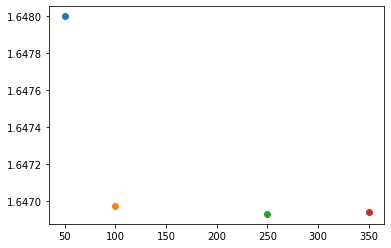

In [68]:
# create and optimise a random forest forecasting model
n_estimators=[10, 50,100, 250, 350] #create a list of values for the number of estimators in the random forest model
for n in n_estimators:
    forest_model = RandomForestRegressor(n_estimators=n, random_state=1)#initialise the random forest model
    forest_model.fit(train_X, train_y)#fit the model
    forest_preds = forest_model.predict(val_X)#predict readings from the validation set
    plt.scatter(n, mean_absolute_error(val_y, forest_preds))#create the impact plot using the mean absolute error

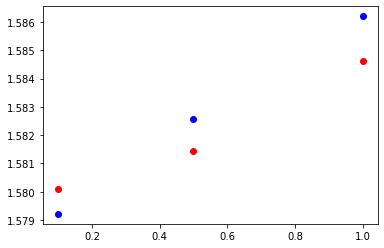

In [81]:
#create and optimise a gradient boost forecasting model
nest=[1200, 1800] # create a list of values for the number of estimators
lra=[ 0.1, 0.5, 1] # create a list of values for the learning rate
for nes in nest:
    if nes==1200:
        co='red'
    elif nes==1800:
        co='blue'
    #elif nes==1000:
       # co='orange'        
    for lr in lra:    
        grad=GradientBoostingRegressor(learning_rate=lr, n_estimators=nes, subsample=1) # initialise the gradient boost model
        grad.fit(train_X, train_y)#fit the model
        grad_preds=grad.predict(val_X)#predict readings from the validation set
        plt.scatter(lr, mean_absolute_error(val_y, grad_preds), c=co)#create the impact plot

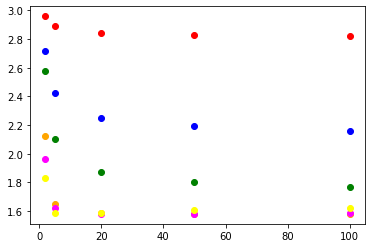

In [77]:
#create and optimise a light GBM regressor     
lnes=[1, 5, 10, 50, 100, 500] #create a list of values for the number of estimators
leaves=[2, 5, 20, 50, 100]# create a list for the number of leaves
for lne in lnes:
    if lne==1:
        co='red'
    elif lne==5:
        co='blue'
    elif lne==10:
        co='green'
    elif lne==50:
        co='orange'
    elif lne==100:
        co='magenta'
    elif lne==500:
        co='yellow'
    
    for le in leaves:
        light = lgm.LGBMRegressor(num_leaves=le, n_estimators=lne)#initialise the lgbm regressor
        light.fit(train_X, train_y)#fit the model
        lpreds=light.predict(val_X)#predict readings from the validation set
        plt.scatter(le, mean_absolute_error(val_y, lpreds), c=co)#create the impact plot

Epoch 1/100
728/728 [==============================] - 2s 2ms/step - loss: 2.8203 - val_loss: 2.1031
Epoch 2/100
728/728 [==============================] - 1s 2ms/step - loss: 1.9865 - val_loss: 1.9560
Epoch 3/100
728/728 [==============================] - 1s 2ms/step - loss: 1.8502 - val_loss: 1.8507
Epoch 4/100
728/728 [==============================] - 1s 2ms/step - loss: 1.8072 - val_loss: 1.7334
Epoch 5/100
728/728 [==============================] - 1s 2ms/step - loss: 1.7874 - val_loss: 2.0087
Epoch 6/100
728/728 [==============================] - 1s 2ms/step - loss: 1.7728 - val_loss: 1.8134
Epoch 7/100
728/728 [==============================] - 1s 2ms/step - loss: 1.7444 - val_loss: 1.7892
Epoch 8/100
728/728 [==============================] - 1s 2ms/step - loss: 1.7346 - val_loss: 1.7300
Epoch 9/100
728/728 [==============================] - 1s 2ms/step - loss: 1.7256 - val_loss: 1.7628
Epoch 10/100
728/728 [==============================] - 1s 2ms/step - loss: 1.7178 - val_lo

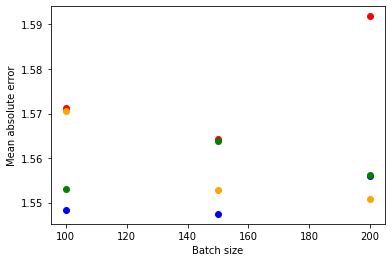

In [85]:
# create and optimise an lstm model for forecasting 
epoc=[100, 500,750,900] #create a list of values for the number of epochs
batch=[100, 150, 200]#create a list of values for the batch size

for e in epoc:
    if e==100:
        co='red'
    if e==500:
        co='orange'
    elif e==750:
        co='blue'
    elif e==900:
        co='green'
     
    for b in batch:
        #initialise model
        lstm_model = keras.Sequential([
                # the hidden ReLU layers
                layers.Dense(units=250, activation='relu', input_shape=[5]),
                layers.Dense(units=250, activation='relu'),
                # the linear output layer 
                layers.Dense(units=1),
            ])
        #compile model with adam optimser and mean absolute error loss function
        lstm_model.compile(
            optimizer="adam",
            loss="mae",)
        #fit model
        lstm_model.fit(
            train_X, train_y,
            validation_data=(val_X, val_y),
            batch_size=b,
            epochs=e,)

        lstm_preds=lstm_model.predict(val_X)
        lstm_model.reset_states()
        print(mean_absolute_error(val_y, lstm_preds))
        print(r2_score(val_y, lstm_preds))
        plt.xlabel('Batch size')
        plt.ylabel('Mean absolute error')
        plt.scatter(b, mean_absolute_error(val_y, lstm_preds), c=co)#create impact plot

In [9]:
#use the optimimum values from the above impact plots for the variables in each of the models and compare the optimal models 
reg=LinearRegression()     
reg.fit(train_X,train_y)
reg_preds=reg.predict(val_X)

dtree = DecisionTreeRegressor(max_depth=10, min_samples_leaf=1, random_state=1)
dtree.fit(train_X, train_y)
dec_preds= dtree.predict(val_X)
        
forest_model = RandomForestRegressor(n_estimators=250, random_state=1)
forest_model.fit(train_X, train_y)
forest_preds = forest_model.predict(val_X)

grad=GradientBoostingRegressor(learning_rate=0.1, n_estimators=2000, subsample=1)
grad.fit(train_X, train_y)
grad_preds=grad.predict(val_X)

light = lgm.LGBMRegressor(num_leaves=50, n_estimators=100)
light.fit(train_X, train_y)
lpreds=light.predict(val_X)

lstm_model = keras.Sequential([
    # the hidden ReLU layers
    layers.Dense(units=250, activation='relu', input_shape=[5]),
    layers.Dense(units=250, activation='relu'),
    # the linear output layer 
    layers.Dense(units=1)
])
lstm_model.compile(
    optimizer="adam",
    loss="mae")

lstm_model.fit(
            train_X, train_y,
            validation_data=(val_X, val_y),
            batch_size=150,
            epochs=750)
lstm_preds=lstm_model.predict(val_X)

#create a data frame of all the optimal models and their performance metrics
compare={'model':['multiple regression', 'decision tree', 'random forest', 'gradient boosting regressor', 'lightgbm', 'lstm'],
        'MAE':[mean_absolute_error(val_y, reg_preds), mean_absolute_error(val_y, dec_preds), mean_absolute_error(val_y, forest_preds),
              mean_absolute_error(val_y, grad_preds), mean_absolute_error(val_y, lpreds), mean_absolute_error(val_y, lstm_preds)],
        'R^2':[r2_score(val_y, reg_preds), r2_score(val_y, dec_preds), r2_score(val_y, forest_preds), 
               r2_score(val_y, grad_preds), r2_score(val_y, lpreds), r2_score(val_y, lstm_preds)]}
compare_df=pd.DataFrame(compare, columns=['model', 'MAE', 'R^2'])
#order the values in ascending order of the mae so that the best model appears at the top 
compare_df=compare_df.sort_values(by=['MAE'])
compare_df.head(8) 

Epoch 1/750
485/485 [==============================] - 2s 4ms/step - loss: 3.0746 - val_loss: 2.2925
Epoch 2/750
485/485 [==============================] - 2s 3ms/step - loss: 2.1078 - val_loss: 1.9023
Epoch 3/750
485/485 [==============================] - 1s 2ms/step - loss: 1.8829 - val_loss: 1.9594
Epoch 4/750
485/485 [==============================] - 1s 2ms/step - loss: 1.8326 - val_loss: 1.7556
Epoch 5/750
485/485 [==============================] - 1s 2ms/step - loss: 1.7941 - val_loss: 1.7508
Epoch 6/750
485/485 [==============================] - 1s 2ms/step - loss: 1.7676 - val_loss: 1.7757
Epoch 7/750
485/485 [==============================] - 1s 3ms/step - loss: 1.7677 - val_loss: 1.7727
Epoch 8/750
485/485 [==============================] - 1s 2ms/step - loss: 1.7618 - val_loss: 1.7696
Epoch 9/750
485/485 [==============================] - 1s 2ms/step - loss: 1.7533 - val_loss: 1.6945
Epoch 10/750
485/485 [==============================] - 1s 2ms/step - loss: 1.7404 - val_lo

,model,MAE,R^2
5,lstm,1.552352,0.678455
3,gradient boosting regressor,1.579344,0.707037
4,lightgbm,1.580633,0.706486
1,decision tree,1.603979,0.697652
2,random forest,1.646930,0.681393
0,multiple regression,2.632492,0.217464


In [10]:
# create a dataframe of just the feature measurements in 2020 
x20=main_20[features]
#use the chosen model (in this case the lstm model was the optimum) to make reading predictions
preds_2020=lstm_model.predict(x20)
#add the predicted readings to the 2020 data frame
main_20['predicted_reading']=preds_2020
main_20=main_20.sort_values(by='timestamp') #order the data in date and time order
main_20.head()

<ipython-input-10-b725da8bd53e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_20['predicted_reading']=preds_2020


,timestamp,reading,Year,Date,Day,Month,Hour,Minute,Holiday,Day_type_as_int,Day_type,Term,Term_as_int,predicted_reading
96953,2020-01-01 00:00:00,5.083333,2020,2020-01-01,Wednesday,1.0,0.0,0.0,New Year's Day,2,Bank_holiday,Christmas_break,2,9.074838
96954,2020-01-01 00:10:00,5.000000,2020,2020-01-01,Wednesday,1.0,0.0,10.0,New Year's Day,2,Bank_holiday,Christmas_break,2,8.564363
96955,2020-01-01 00:20:00,5.500000,2020,2020-01-01,Wednesday,1.0,0.0,20.0,New Year's Day,2,Bank_holiday,Christmas_break,2,8.595479
96956,2020-01-01 00:30:00,6.250000,2020,2020-01-01,Wednesday,1.0,0.0,30.0,New Year's Day,2,Bank_holiday,Christmas_break,2,8.601401
96957,2020-01-01 00:40:00,5.500000,2020,2020-01-01,Wednesday,1.0,0.0,40.0,New Year's Day,2,Bank_holiday,Christmas_break,2,8.621977


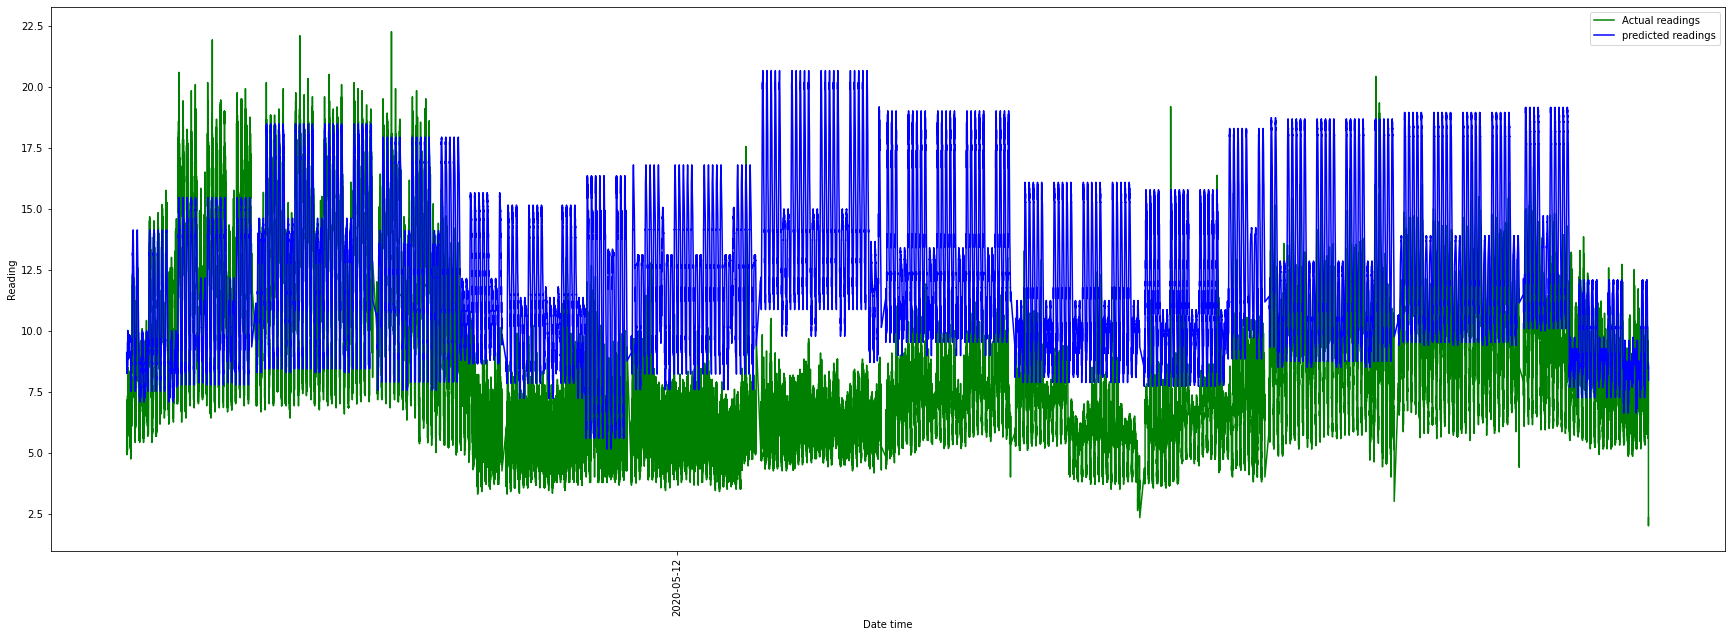

In [12]:
#plot the predicted and actual measured readings in 2020 to visually compare
fig, ax = plt.subplots(figsize=(30, 10))

plt.xticks(rotation='vertical')

plt.plot(main_20.timestamp, main_20['reading'], c='green')

plt.plot(main_20.timestamp, main_20['predicted_reading'], c='blue')

plt.xlabel('Date time')
plt.ylabel('Reading')
plt.legend(['Actual readings', 'predicted readings'])
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=50))
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
plt.show()

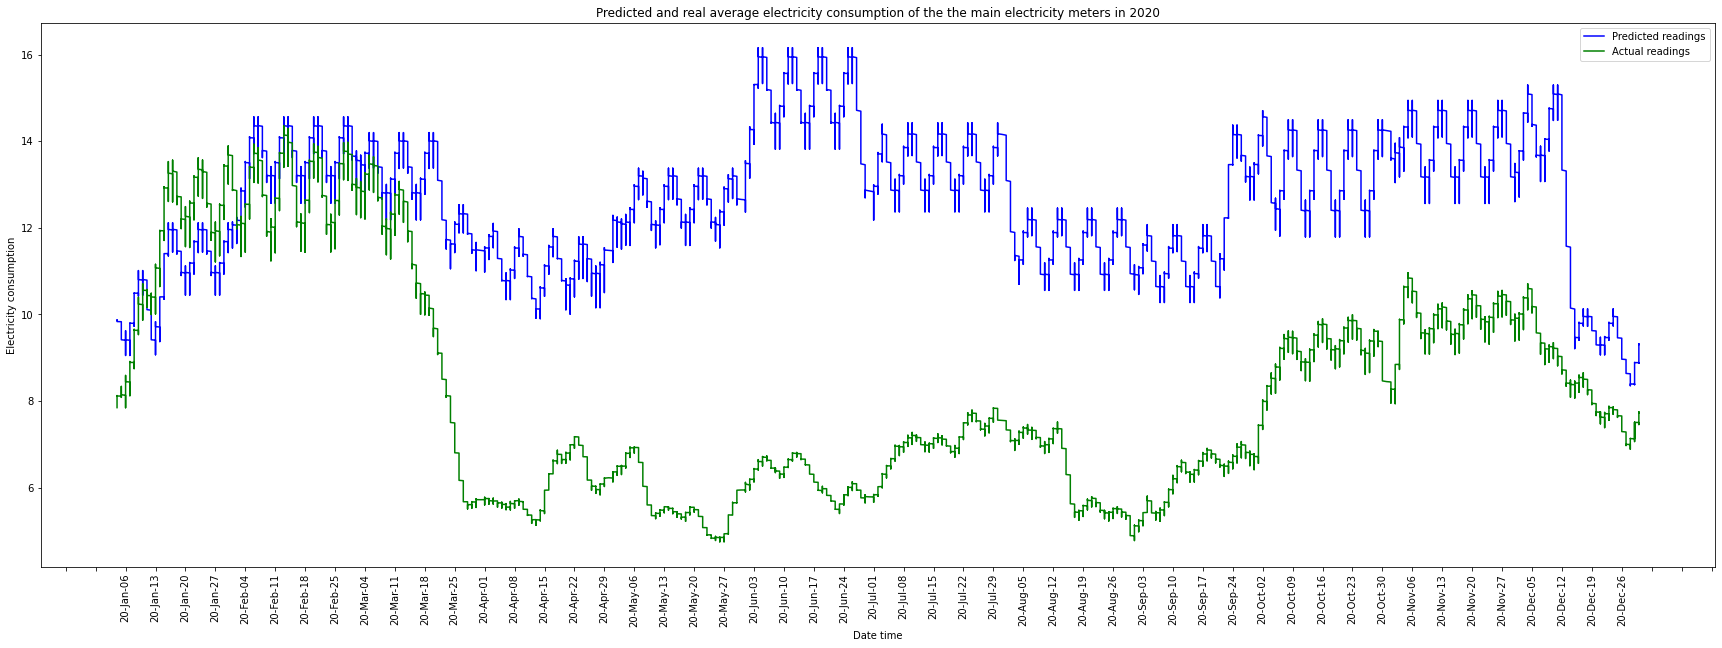

In [13]:
#plot the rolling average of the predicted and true readings to make visualisation more comprehensive
main_20[ 'predicted_rolling_avg' ] = main_20.predicted_reading.rolling(500).mean()
main_20[ 'real_rolling_avg' ] = main_20.reading.rolling(500).mean()
main_20['month_day']=main_20['timestamp'].apply(lambda x:pd.Timestamp(x).strftime('%y-%b-%d'))

fig, ax = plt.subplots(figsize=(30, 10))

plt.xticks(rotation='vertical')

ax.plot(main_20.month_day, main_20['predicted_rolling_avg'], c='blue')

ax.plot(main_20.month_day, main_20['real_rolling_avg'], c='green')

plt.xlabel('Date time')
plt.ylabel('Electricity consumption')
plt.legend(['Predicted readings', 'Actual readings'])
plt.title('Predicted and real average electricity consumption of the the main electricity meters in 2020')



plt.show()

In [14]:
print('The mean absolute error between the predicted consumption readings in 2020 and the measured readings is ', mean_absolute_error(main_20['predicted_reading'], main_20['reading']))

The mean absolute error between the predicted consumption readings in 2020 and the measured readings is  4.542860206064673
